<a href="https://colab.research.google.com/github/sazio/MultiAgentCovid/blob/master/Neighborhood_SIR_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

from scipy import integrate, optimize # Curve fitting (SIR Model)
from prettytable import PrettyTable # For a nice report (visualization)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [22]:
path = "drive/MyDrive/MAS/Data/"
cases_toronto_df =  pd.read_csv(path +"CasesToronto.csv")
cases_toronto_df["Episode Date"] = pd.to_datetime(cases_toronto_df["Episode Date"])

### 1st Neighborhood (West Humber-Clairville)

In [37]:
# Extracting our neighborhood 
cases_neigh_df = cases_toronto_df[cases_toronto_df["Neighbourhood Name"] == "West Humber-Clairville"]
cases_neigh_df = cases_neigh_df.reset_index(drop = True)

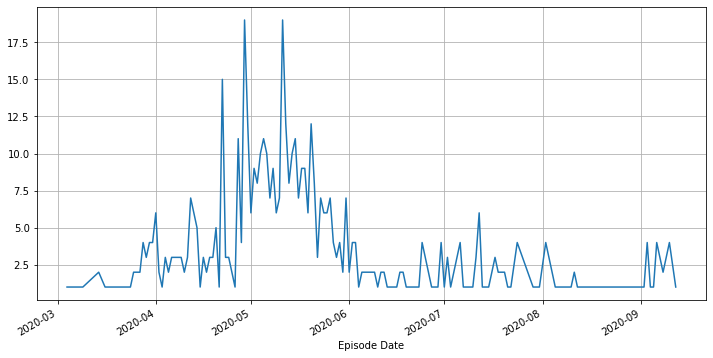

In [53]:
fig, ax = plt.subplots(1,1, figsize = (12, 6))
cases_neigh_df.groupby(["Episode Date"]).count()["_id"].plot(ax = ax, grid = True)

Taking asymptomatics into account (~82% of infected people is asymptomatic)

Ref : https://med.stanford.edu/content/dam/sm/id/documents/COVID/AsymptCOVID_TransmissionShip.pdf 

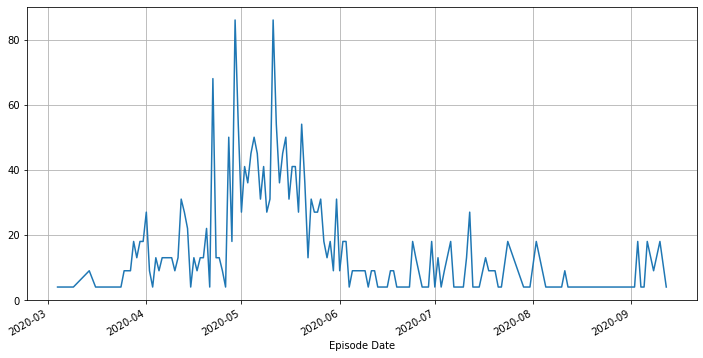

In [73]:
total_infected_neigh = cases_neigh_df.groupby(["Episode Date"]).count()["_id"]*(0.82/0.18)
total_infected_neigh = total_infected_neigh.astype(int)

fig, ax = plt.subplots(1,1, figsize = (12, 6))
total_infected_neigh.plot(ax = ax, grid = True)

Filling missing indices (some dates aren't reported) 

In [126]:
new_idx = pd.date_range('03-04-2020', '09-12-2020')

total_infected_neigh.index = pd.DatetimeIndex(total_infected_neigh.index)
total_infected_neigh = total_infected_neigh.reindex(new_idx, fill_value= 0 )
total_infected_neigh = total_infected_neigh.replace(0, np.nan)
total_infected_neigh = total_infected_neigh.interpolate(method="quadratic") 
total_infected_neigh = total_infected_neigh.astype(int)

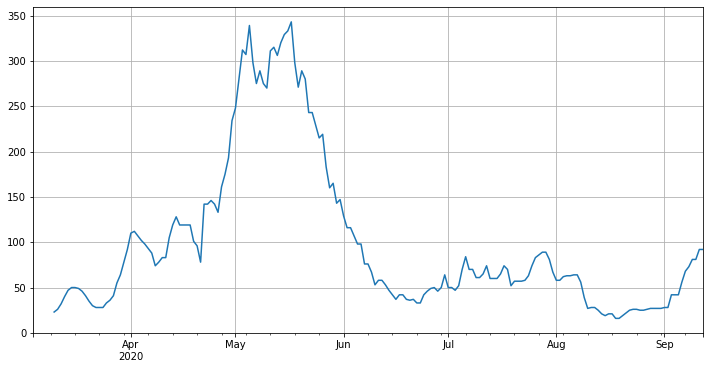

In [144]:
# Moving Average plot 
days = 7
total_mov_avg = total_infected_neigh.rolling(days).sum()
total_mov_avg.plot(figsize = (12,6), grid = True)


## Curve Fitting (SIR Model)

In [159]:
x_data = np.array([i for i in range(0,total_mov_avg.index.shape[0])]).astype(float)[days-1:]
y_data = total_mov_avg.values.astype(float)[days-1:]

In [161]:
# Defining SIR Model 
def sir_model(y, x, beta, gamma):
    S = -beta * y[0] * y[1] / N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

# ODE integration 
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]


In [162]:
N = 33312 # see Neighborhood Profiles in GIS_Data_Toronto.ipynb
I0 = y_data[0]
S0 = N - I0
R0 = 0.0

In [163]:
popt, pcov = optimize.curve_fit(fit_odeint, x_data, y_data)
fitted = fit_odeint(x_data, *popt)

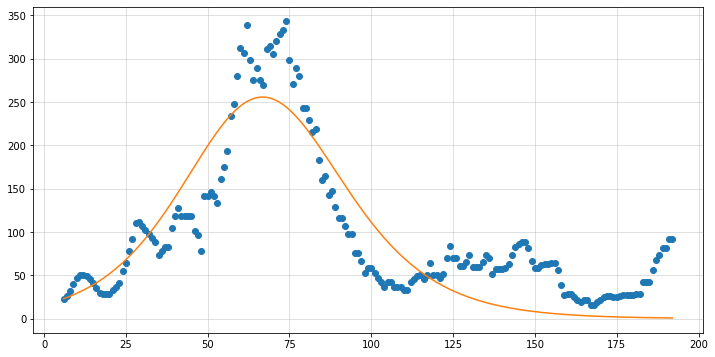

In [169]:
fig, ax = plt.subplots(1,1, figsize = (12, 6))
ax.grid(alpha = 0.5)
ax.plot(x_data, y_data, 'o')
ax.plot(x_data, fitted)

In [180]:
# Visualize Fitting Parameters | SIR Model 
report = PrettyTable()

report.field_names = ["Moving Avg", "Beta", "Gamma"]
report.add_row(["7 Days", "%.2f" % popt[0], "%.2f" % popt[1]])

print(report)

+------------+------+-------+
| Moving Avg | Beta | Gamma |
+------------+------+-------+
|   7 Days   | 0.51 |  0.45 |
+------------+------+-------+
